# Multi-spectral modelling of an RC telescope

Based on Toliman design, with no phase grating. This is just a demonstration of the approach for modelling a single stellar source image.

In [1]:
import numpy as np

toliman_settings = {
                    # Eduardo's values:
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 0.5717255, 
                    'm1_m2_sep': 0.54933763033373, 
                    'm2_fl': -0.02337895948640,  
                    'bfl': 0.52761,# Adjusted value to get proper focus (from BN)
                    'm2_rad': 0.00590401477581,
                    'm1_conic': -1.00011470000000,
                    'm2_conic': -1.16799179177759,
                    # Go for 5-fold symmetry to match assumed rosette
                    'm2_strut_width': 0.01,
                    'm2_supports': 5
                    }
prescription_vals = toliman_settings
prescription_vals['beam_ratio'] = 0.2
prescription_vals['tilt_x'] = 0.
prescription_vals['tilt_y'] = 0.

n_wavelengths = 5
wl_min = 0.5 # micros -> 500 nm
wl_max = 0.6 # micros -> 600 nm
wavelengths = np.linspace(wl_min, wl_max, num=n_wavelengths)
print(wavelengths)

[ 0.5    0.525  0.55   0.575  0.6  ]


## Individual monochromatic PSFs

In [2]:
%matplotlib inline
import proper
import numpy as np
import matplotlib.pylab as plt

def plot_psfs(prescription,
                    prescription_vals,
                    wavelengths=[0.6],
                    gridsize = 2048, #512
                    sz = 80):
    c = int(gridsize/2)

    fig, axes = plt.subplots(nrows=1, ncols=len(wavelengths),sharex=True, sharey=True, figsize=(10,2))
    it = iter(axes.flat)
    for wl in wavelengths:
        (wavefront, sampling) = proper.prop_run(prescription, wl, gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=prescription_vals)
        ax = next(it)
        im = ax.imshow(np.log10(wavefront[c-sz:c+sz, c-sz:c+sz]), interpolation = 'none', cmap='viridis', clim=[-7, -1.6])
#    fig.subplots_adjust(hspace=0, wspace=0)
#    plt.setp([a.get_xticklabels() for a in fig.axes], visible=False)
#    plt.setp([a.get_yticklabels() for a in fig.axes], visible=False)
#    plt.setp([a.get_yticklabels() for a in fig.axes[::len(offsets_x)]], visible=True)
#    plt.setp([a.get_xticklabels() for a in fig.axes[-len(offsets_x):]], visible=True)
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


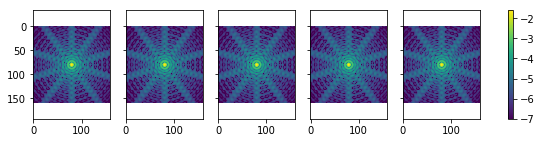

In [10]:
%matplotlib inline
   
plot_psfs('prescription_rc_conic', prescription_vals, wavelengths=wavelengths)

##  Combined version using `prop_run_multi`

In [3]:
gridsize = 2048
(wavefronts, sampling) = proper.prop_run_multi('prescription_rc_conic', wavelengths, gridsize = gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=prescription_vals)

TypeError: Image data cannot be converted to float

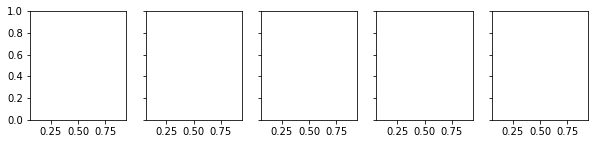

In [12]:
c = int(gridsize/2)
sz = 80
fig, axes = plt.subplots(nrows=1, ncols=len(wavelengths),sharex=True, sharey=True, figsize=(10,2))
it = iter(axes.flat)
for i in range(n_wavelengths):
    ax = next(it)
    im = ax.imshow(np.log10(wavefronts[i][c-sz:c+sz, c-sz:c+sz]), interpolation = 'none', cmap='viridis', clim=[-7, -1.6])
#    fig.subplots_adjust(hspace=0, wspace=0)
#    plt.setp([a.get_xticklabels() for a in fig.axes], visible=False)
#    plt.setp([a.get_yticklabels() for a in fig.axes], visible=False)
#    plt.setp([a.get_yticklabels() for a in fig.axes[::len(offsets_x)]], visible=True)
#    plt.setp([a.get_xticklabels() for a in fig.axes[-len(offsets_x):]], visible=True)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [7]:
# Copied from manual
# resample fields to same scale, convert to PSFs
gridsize = 2048
final_sampling = 1.5e-6 # m/pixel
npsf = gridsize
psfs = np.zeros([n_wavelengths, npsf, npsf], dtype = np.float64)
for i in range(n_wavelengths):
    mag = sampling[i] / final_sampling
    field = proper.prop_magnify(wavefronts[i,:,:], mag, npsf, CONSERVE = True)
    psfs[i,:,:] = np.abs(field)**2
# add PSFs together
psf = np.sum(psfs, axis = 0) / n_wavelengths

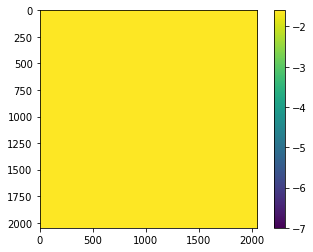

In [9]:
import matplotlib.pyplot as plt

plt.imshow(psf, interpolation = 'none', cmap='viridis', clim=[-7, -1.6])
plt.colorbar()
plt.show()